In [360]:
# https://www.kaggle.com/code/farzadnekouei/polynomial-regression-regularization-assumptions#Step-8:-Build-Linear-Regression-Model

# 1. import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

/Users/shengnan/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# 2. import data

In [2]:
df = pd.read_csv('Car details v3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [4]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [5]:
df.describe(include='object') 

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,8128,8128,8128,8128,8128,7907,7907,7913,7906
unique,2058,4,3,2,5,393,121,322,441
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,129,4402,6766,7078,5289,225,1017,377,530


# 3. data processing

In [6]:
#### convert manufacture year to Age
df.insert(0, "Age", df["year"].max()+1-df["year"] )
df.drop('year',axis=1,inplace=True)
df.head()

,Age,name,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,7,Maruti Swift Dzire VDI,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,7,Skoda Rapid 1.5 TDI Ambition,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,15,Honda City 2017-2020 EXi,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,11,Hyundai i20 Sportz Diesel,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,14,Maruti Swift VXI BSIII,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [7]:
#remove same funcion cols
df.drop('name',axis=1,inplace=True)
df.drop('torque',axis=1,inplace=True) # similar with max_power
df.drop('mileage',axis=1,inplace=True) # same with km_driven

In [8]:
# convert engine and max_power to numeric values
df.engine=df.engine.str.extract('(\d+)')
df.max_power=df.max_power.str.extract('(\d+)')
df.engine = pd.to_numeric(df['engine'])
df.max_power = pd.to_numeric(df['max_power'])

In [9]:
OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values, 
                              df.select_dtypes(include='object').columns.values])

In [10]:
for i,col in enumerate(OrderedCols):
    print(i,col)

0 Age
1 selling_price
2 km_driven
3 engine
4 max_power
5 seats
6 fuel
7 seller_type
8 transmission
9 owner


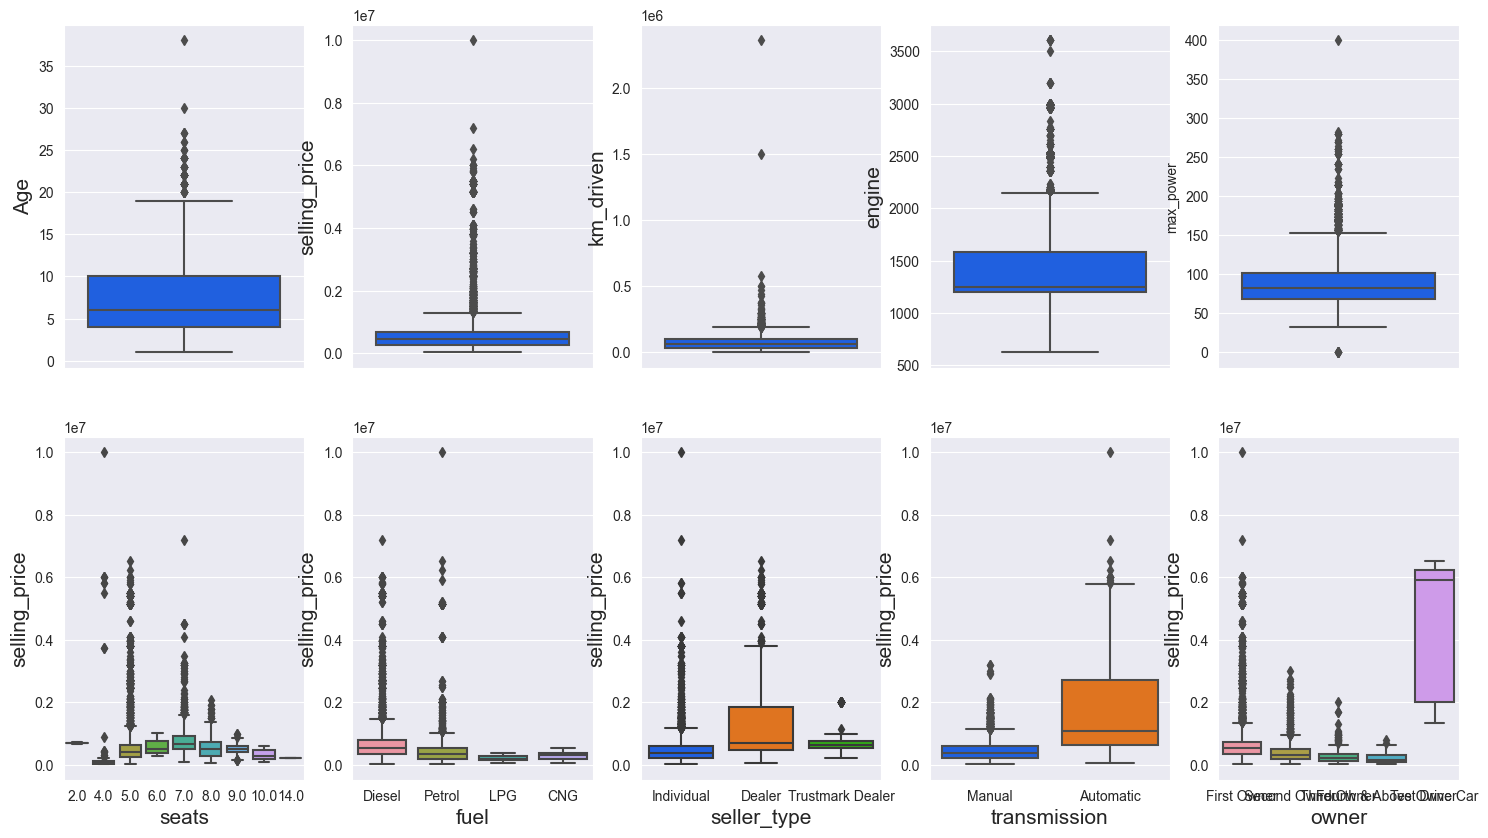

In [11]:
# 2X5 visual plot - 1st row numeric cols dist; 2nd row categorical cols vs. selling price
# identify outliers
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(2, 5, figsize=(18,10),dpi=100)
for i,col in enumerate(OrderedCols):
    if i in [0,1,2,3,4]:
#         print(i//5,i%5)
        sns.boxplot(data=df,y=col,ax=ax[i//5,i%5])
        ax[i//4,i%4].yaxis.label.set_size(15)
    elif i in [5,6,7,8,9]:
#         print(i//5,i%5)
        sns.boxplot(data=df, x=col, y='selling_price', ax=ax[i//5,i%5])
        ax[i//5,i%5].xaxis.label.set_size(15)
        ax[i//5,i%5].yaxis.label.set_size(15)

In [12]:
outliers_indexes = []
target = 'selling_price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())

In [13]:
for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())

In [14]:
outliers_indexes = list(set(outliers_indexes)) #return unique index
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

2358 outliers were identified, whose indices are:

[7, 16, 27, 29, 35, 37, 39, 40, 41, 47, 48, 49, 51, 55, 56, 57, 58, 59, 60, 75, 77, 80, 82, 103, 105, 108, 110, 127, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 146, 148, 149, 151, 156, 157, 158, 163, 165, 166, 167, 168, 169, 170, 177, 186, 187, 188, 199, 212, 219, 233, 234, 238, 239, 243, 244, 249, 257, 258, 265, 270, 271, 272, 276, 277, 285, 286, 287, 288, 289, 297, 310, 311, 312, 313, 316, 318, 320, 330, 340, 345, 350, 358, 359, 362, 363, 369, 370, 371, 372, 373, 374, 375, 379, 384, 385, 388, 391, 394, 396, 397, 399, 401, 404, 409, 410, 411, 412, 413, 414, 418, 423, 424, 427, 432, 435, 437, 441, 444, 447, 452, 457, 461, 463, 466, 468, 470, 471, 475, 476, 483, 487, 500, 506, 508, 515, 519, 526, 531, 532, 543, 544, 548, 550, 556, 569, 570, 575, 576, 577, 579, 584, 587, 588, 595, 597, 600, 603, 604, 609, 610, 613, 616, 621, 622, 627, 628, 632, 637, 640, 641, 642, 646, 647, 648, 649, 650, 651, 655, 660, 661, 66

29


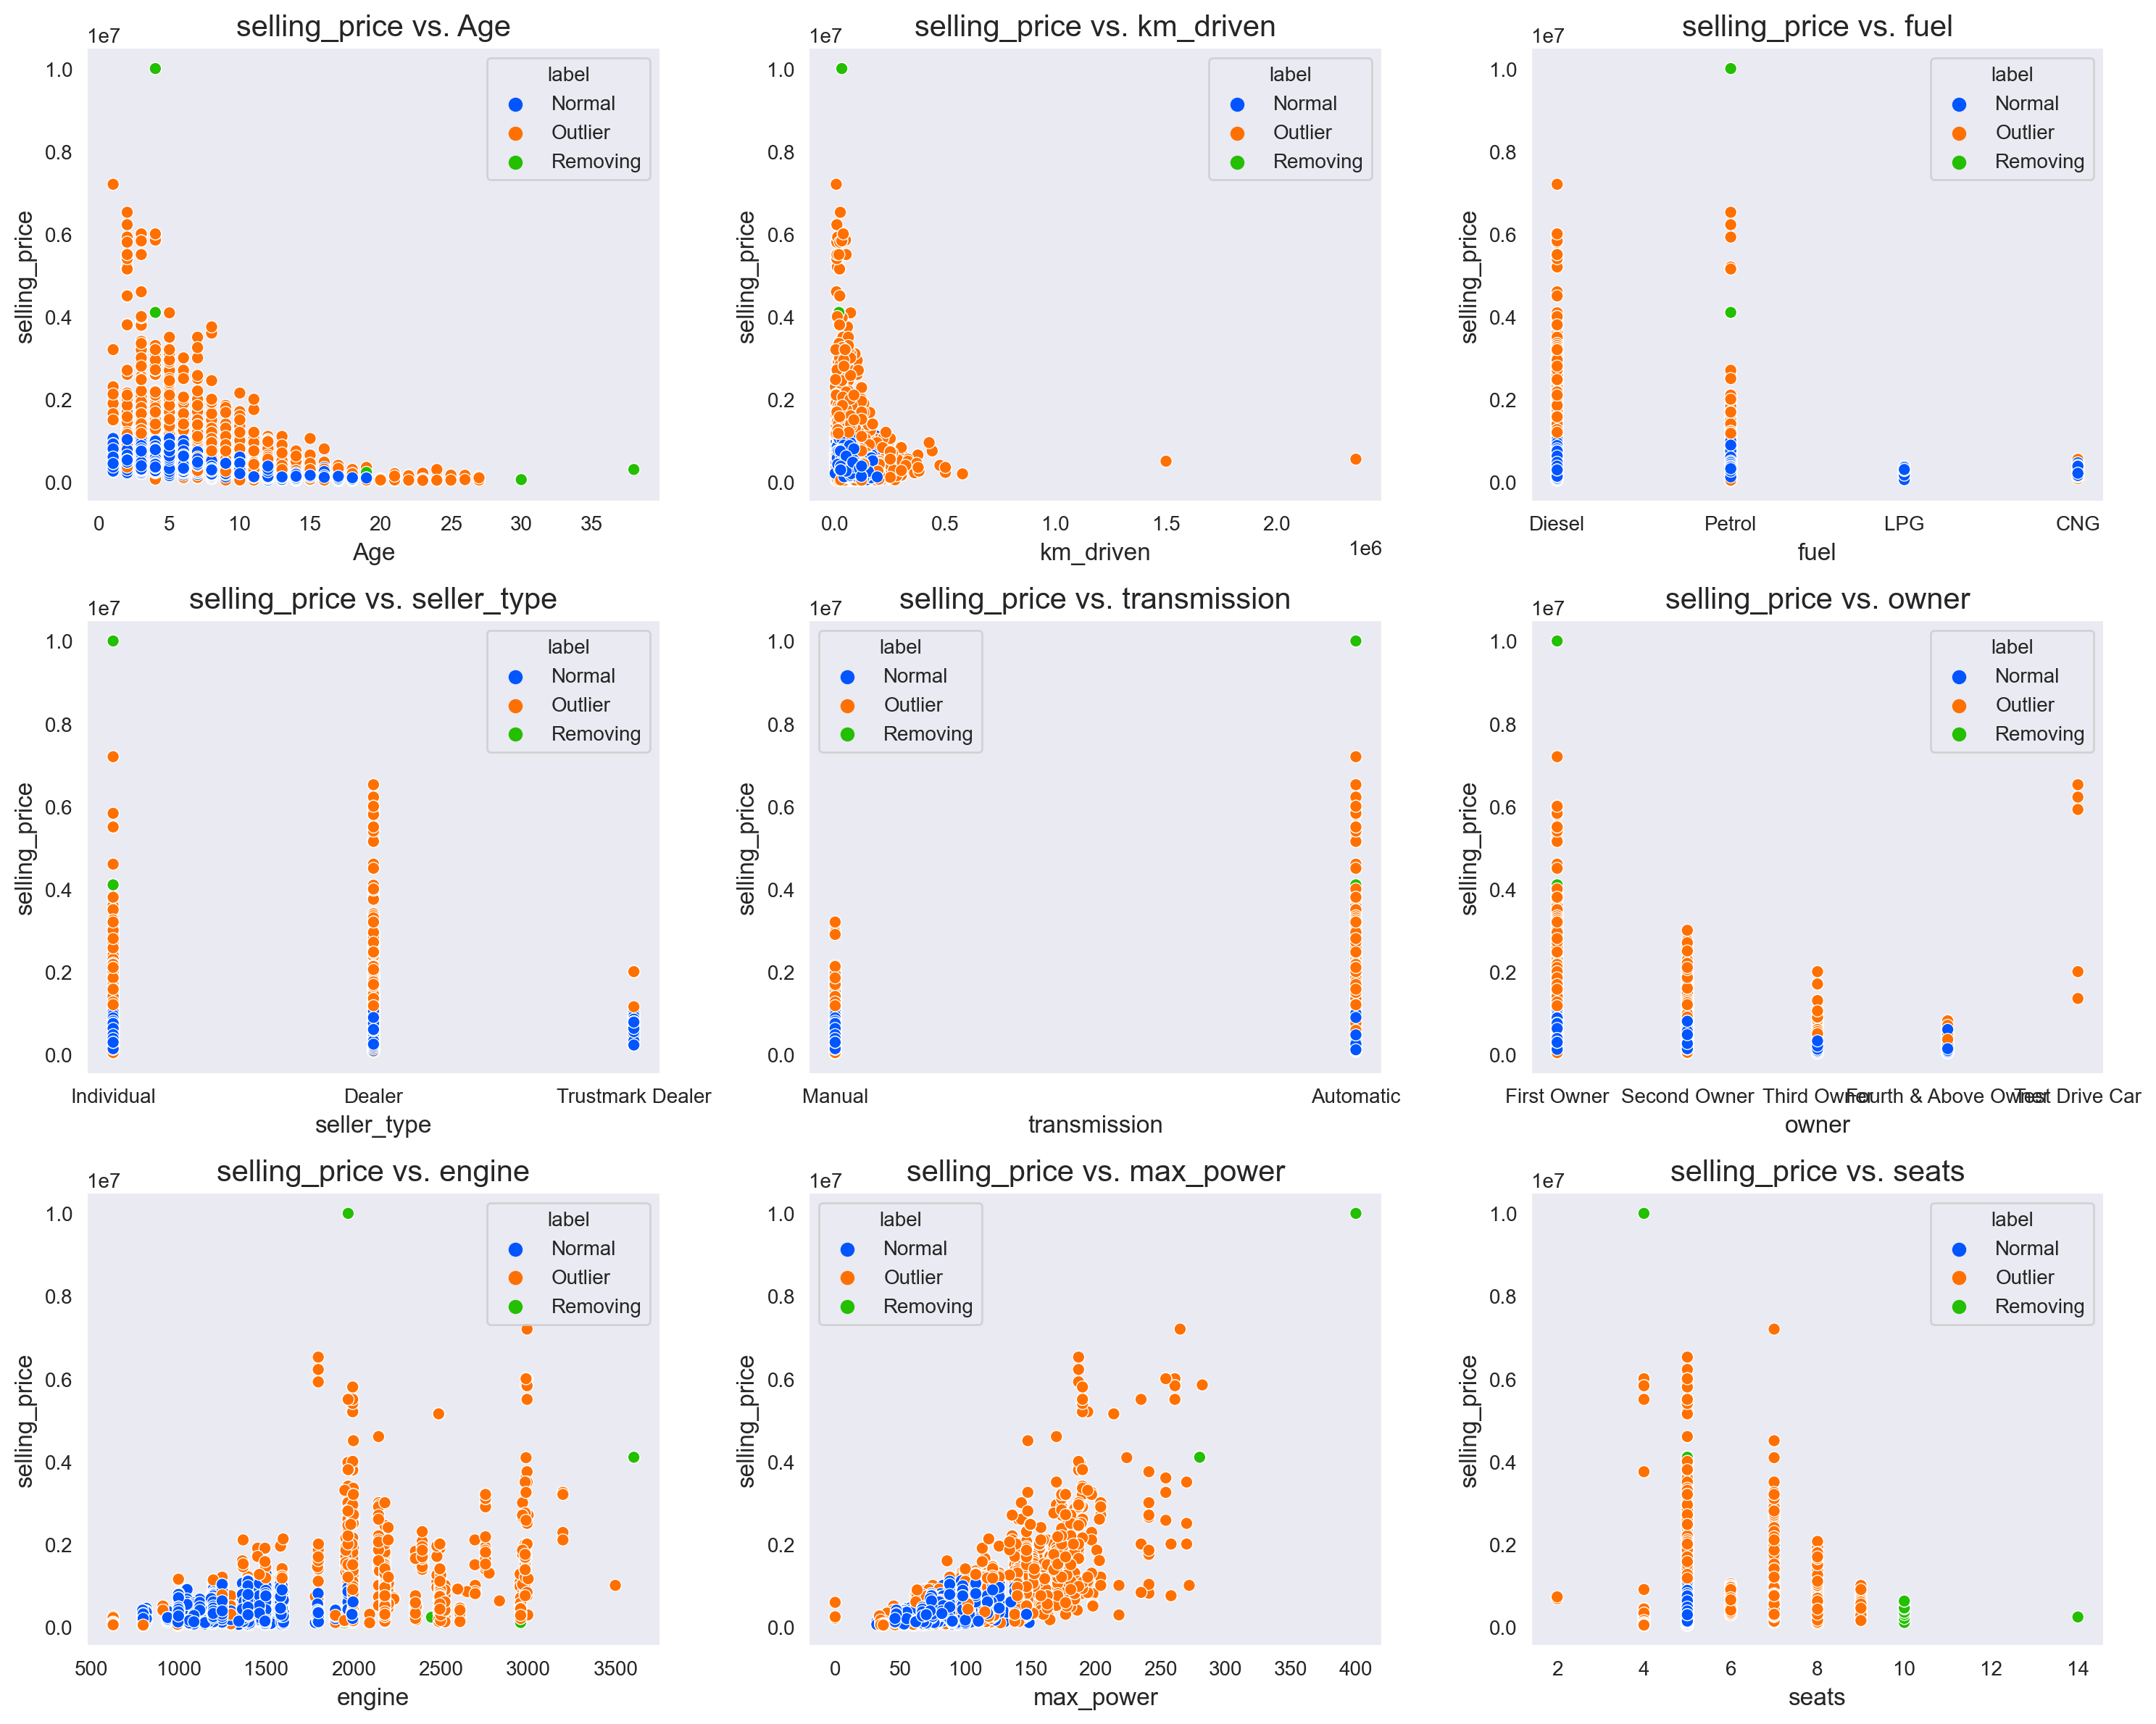

In [15]:
# Outliers Labeling
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>10000000].index)
removing_indexes.extend(df1[df1['Age']>=30].index)
removing_indexes.extend(df1[df1['km_driven']>15000000].index)
removing_indexes.extend(df1[df1['engine']>=3500].index)
removing_indexes.extend(df1[df1['max_power']>=400].index)
removing_indexes.extend(df1[df1['seats']>=10].index)
df1.loc[removing_indexes,'label'] = 'Removing'
print(len(set(removing_indexes))) #29

# Plot
target = 'selling_price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

# ax[2, 1].axis('off')
# ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [16]:
# drop outliers
removing_indexes
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True) #removed 29 outliers

In [18]:
# drop null values
df1.isnull().sum()
df1.dropna(axis=0,inplace=True)

Age              0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
engine           0
max_power        0
seats            0
dtype: int64

In [19]:
# drop duplicates
df1.drop_duplicates(inplace=True)

# 4. EDA

In [21]:
df1.seats=df1.seats.astype(int)

In [22]:
df1.seats = df1.seats.apply(str)

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6661 entries, 0 to 8096
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            6661 non-null   int64  
 1   selling_price  6661 non-null   int64  
 2   km_driven      6661 non-null   int64  
 3   fuel           6661 non-null   object 
 4   seller_type    6661 non-null   object 
 5   transmission   6661 non-null   object 
 6   owner          6661 non-null   object 
 7   engine         6661 non-null   float64
 8   max_power      6661 non-null   float64
 9   seats          6661 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 572.4+ KB


## 4.1 categorical columns

In [25]:
CatCols = list(df1.select_dtypes(include=object).columns.values)

In [26]:
CatCols

['fuel', 'seller_type', 'transmission', 'owner', 'seats']

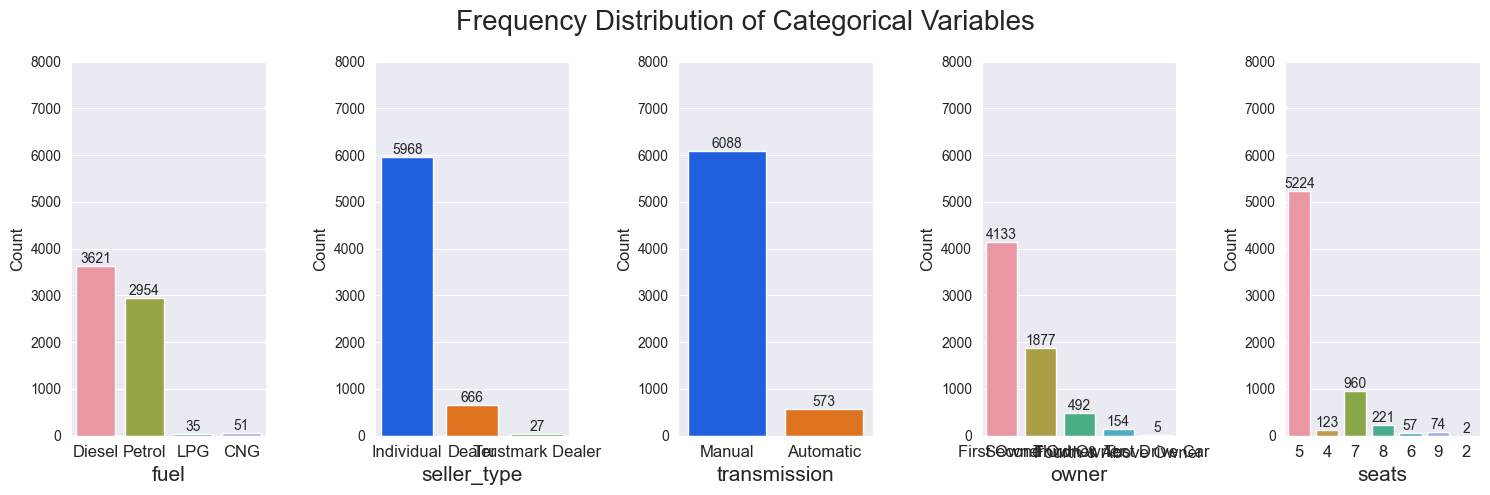

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
       
for i in range(len(CatCols)):
    graph = sns.countplot(x=CatCols[i], data=df1, ax=ax[i])
    ax[i].set_xlabel(CatCols[i], fontsize=15)
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0,8000])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20) 
plt.tight_layout()
plt.show()

In [28]:
from matplotlib import cm

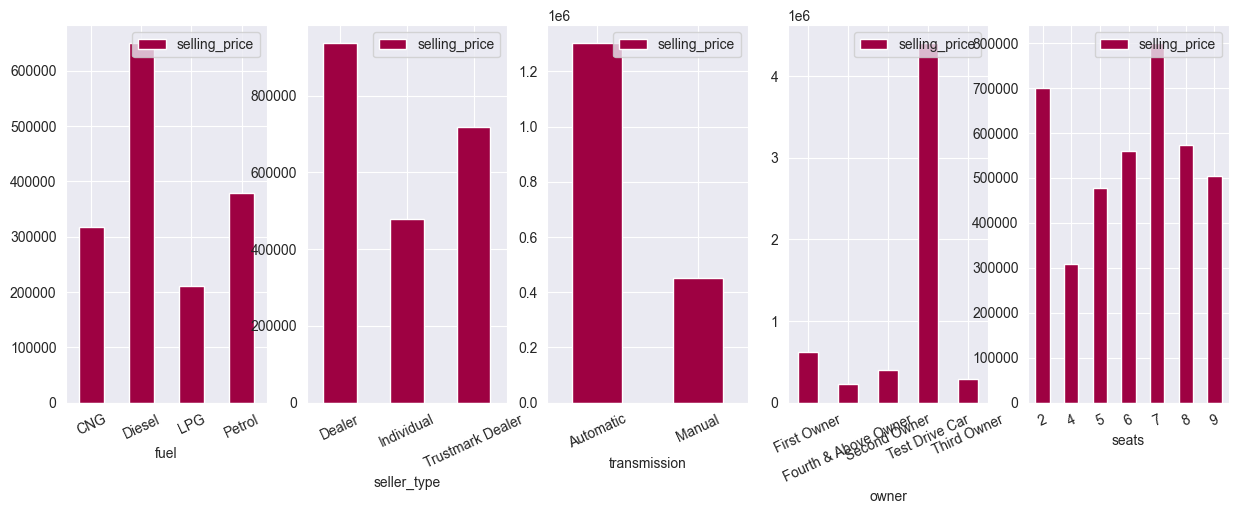

In [29]:
cols_name = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,5), dpi=100)
for i in range(len(cols_name)):
    df1[[cols_name[i],'selling_price']].groupby(cols_name[i]).mean().plot(kind='bar',rot=25,ax=ax[i],colormap=cm.get_cmap('Spectral'))

In [30]:
# selling price by fuel
df1[['fuel','selling_price']].groupby(['fuel']).median().round()

,selling_price
fuel,
CNG,330000.0
Diesel,530000.0
LPG,200000.0
Petrol,320000.0


In [31]:
# selling price by seller_type
df1[['selling_price','seller_type']].groupby(['seller_type']).median().round()
# diff between dealer and individual is more significant than dealer vs. trustmark dealer

,selling_price
seller_type,
Dealer,625000.0
Individual,400000.0
Trustmark Dealer,650000.0


In [32]:
# selling price by transmission
df1[['selling_price','transmission']].groupby(['transmission']).median().round()

,selling_price
transmission,
Automatic,850000.0
Manual,400000.0


In [33]:
# selling price by owner type
df1[['selling_price','owner']].groupby(['owner']).median().round()

,selling_price
owner,
First Owner,500000.0
Fourth & Above Owner,185000.0
Second Owner,320000.0
Test Drive Car,5923000.0
Third Owner,229999.0


In [34]:
# selling price by seat number
df1[['selling_price','seats']].groupby(['seats']).median().round()
# 2 seats cars are sports car
# 7 seats cars are van

,selling_price
seats,
2,700500.0
4,65000.0
5,380000.0
6,480000.0
7,675000.0
8,500000.0
9,505000.0


## 4.2 numeric columns

In [35]:
list(df1.select_dtypes(exclude=object).columns.values)

['Age', 'selling_price', 'km_driven', 'engine', 'max_power']

In [36]:
NumCols = list(list(df1.select_dtypes(exclude=object).columns.values))

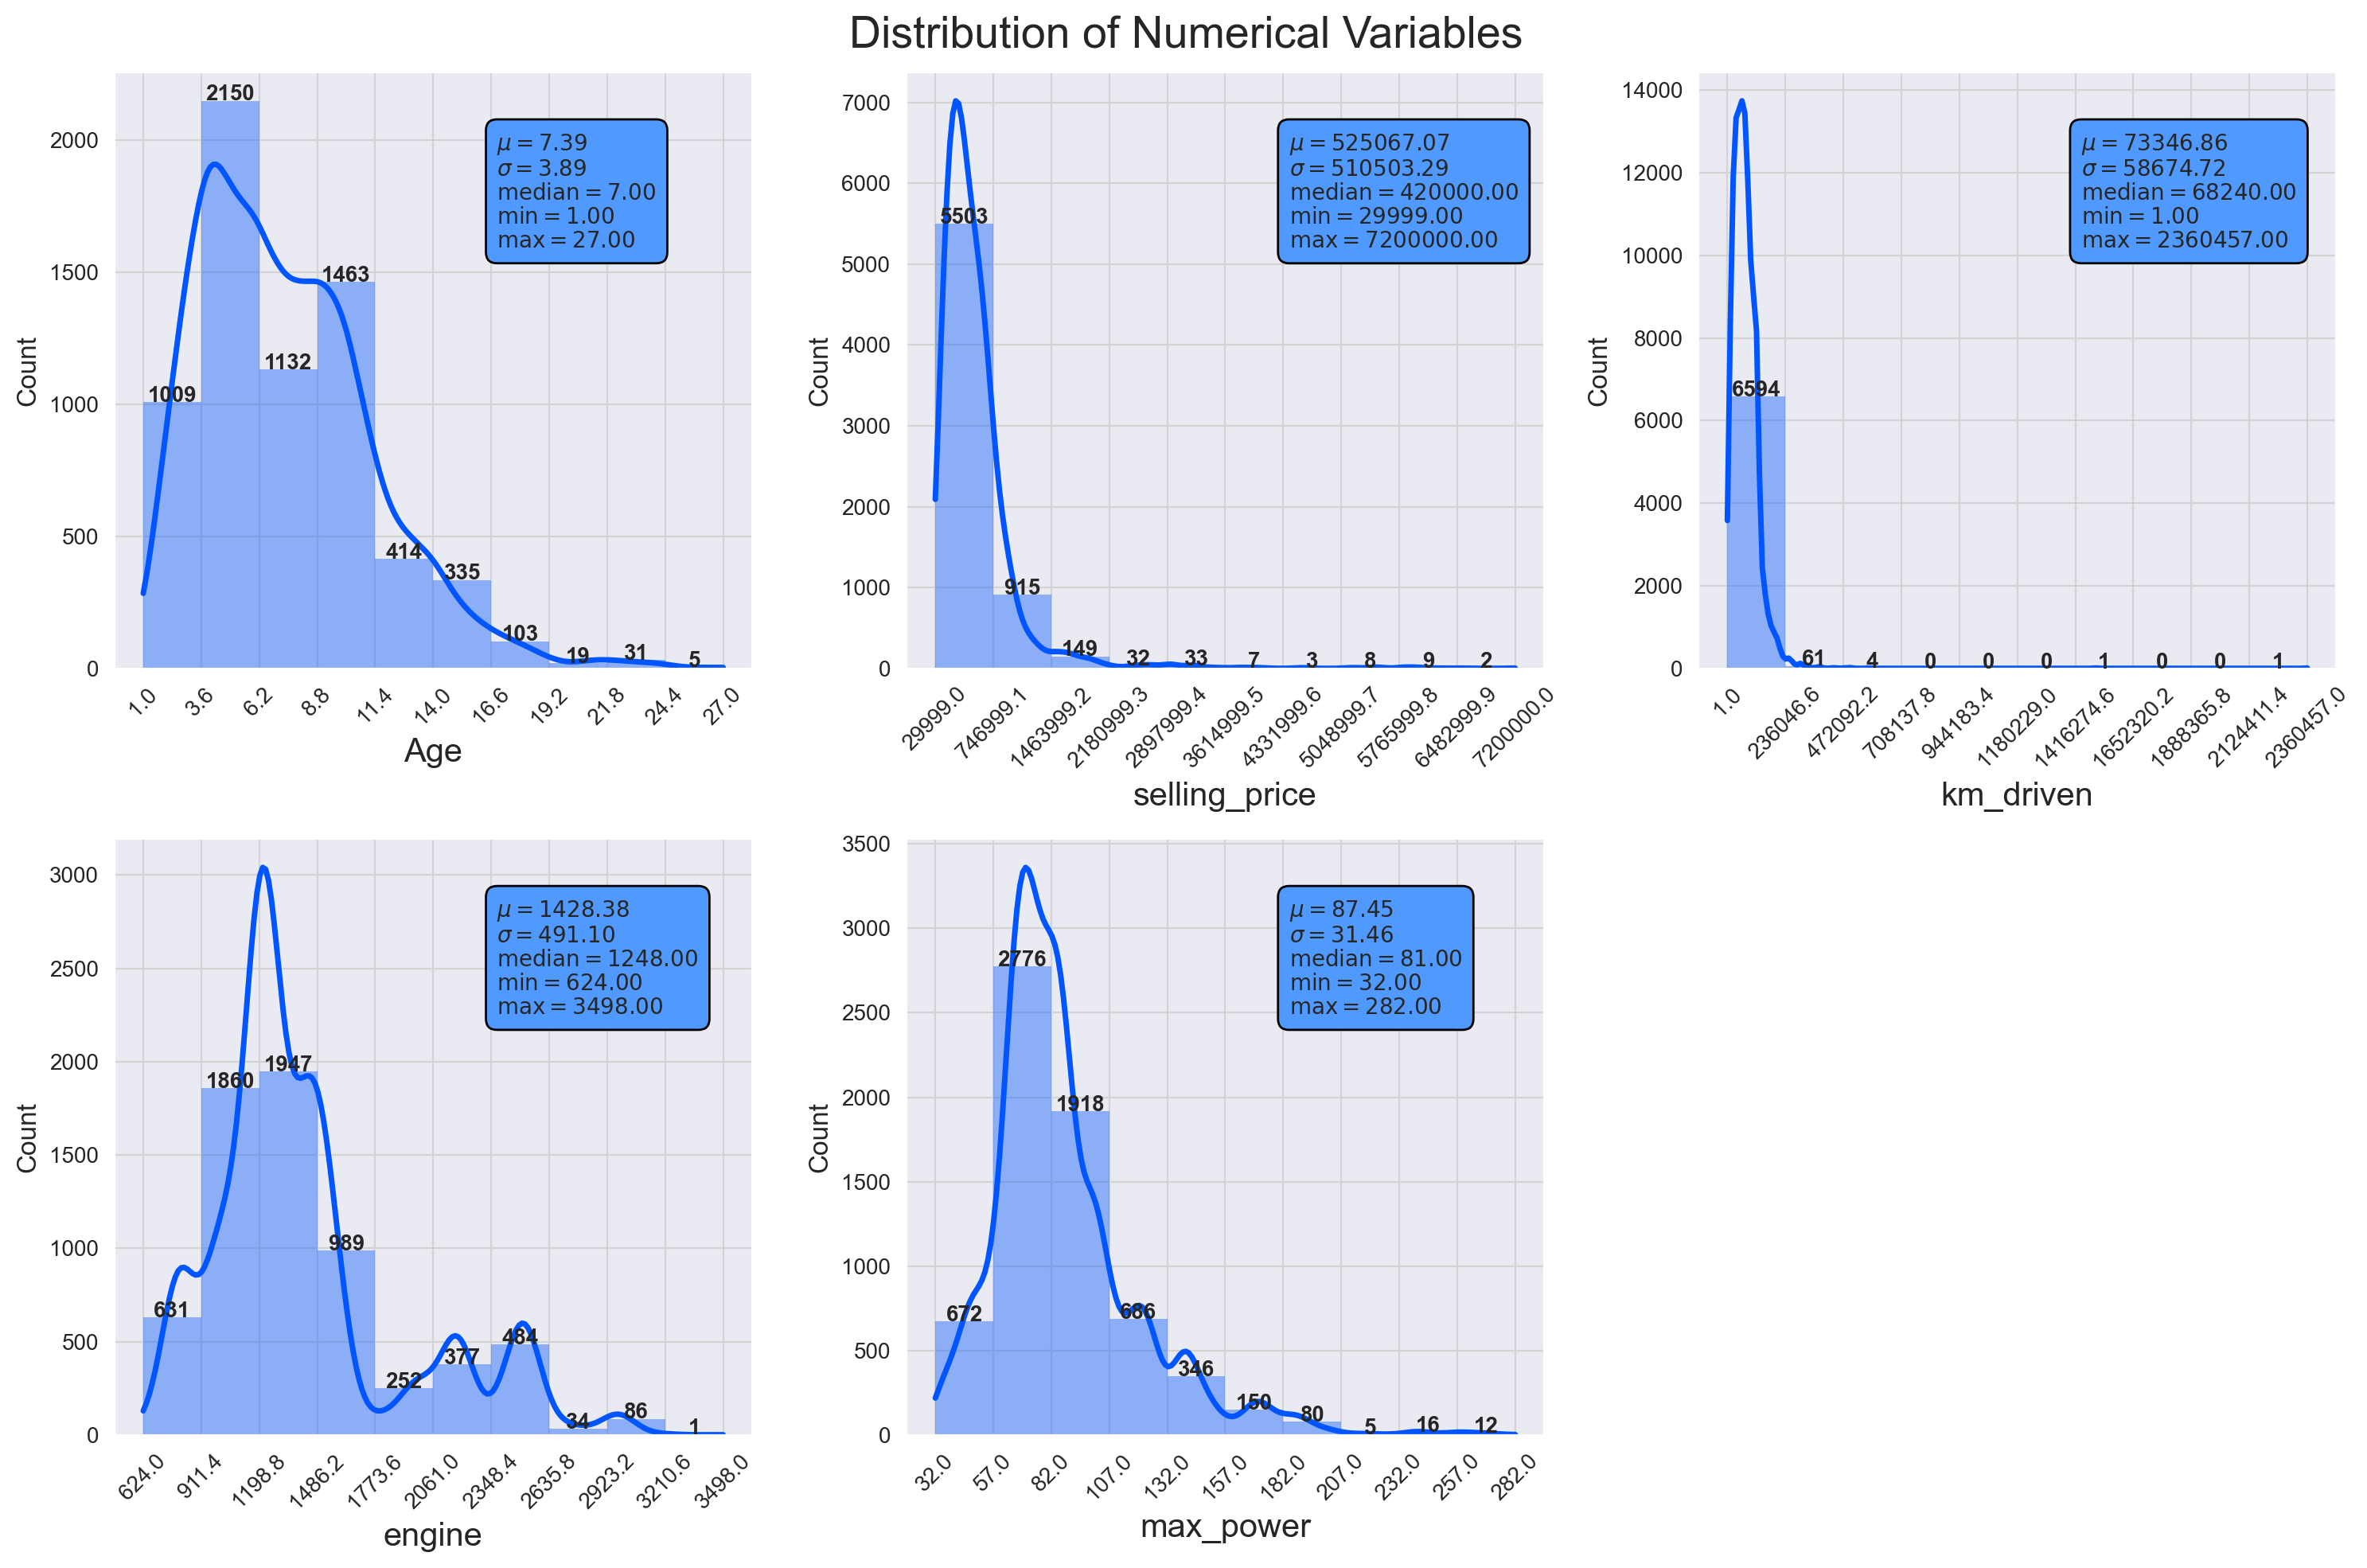

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)
c = '#0055ff'

for i in range(len(NumCols)):
    row = i//3
    col = i%3
    values, bin_edges = np.histogram(df1[NumCols[i]], 
                                     range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))                
    graph = sns.histplot(data=df1, x=NumCols[i], bins=bin_edges, kde=True, ax=ax[row,col],
                         edgecolor='none', color=c, alpha=0.4, line_kws={'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize=15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges,1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticks(), rotation = 45)
    ax[row,col].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
    ))
    ax[row,col].text(0.6, 0.9, textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))
    
ax[1, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20) 
plt.tight_layout()   
plt.show()

## 4.3 Target vs. Numerical Features Bivariate Analysis

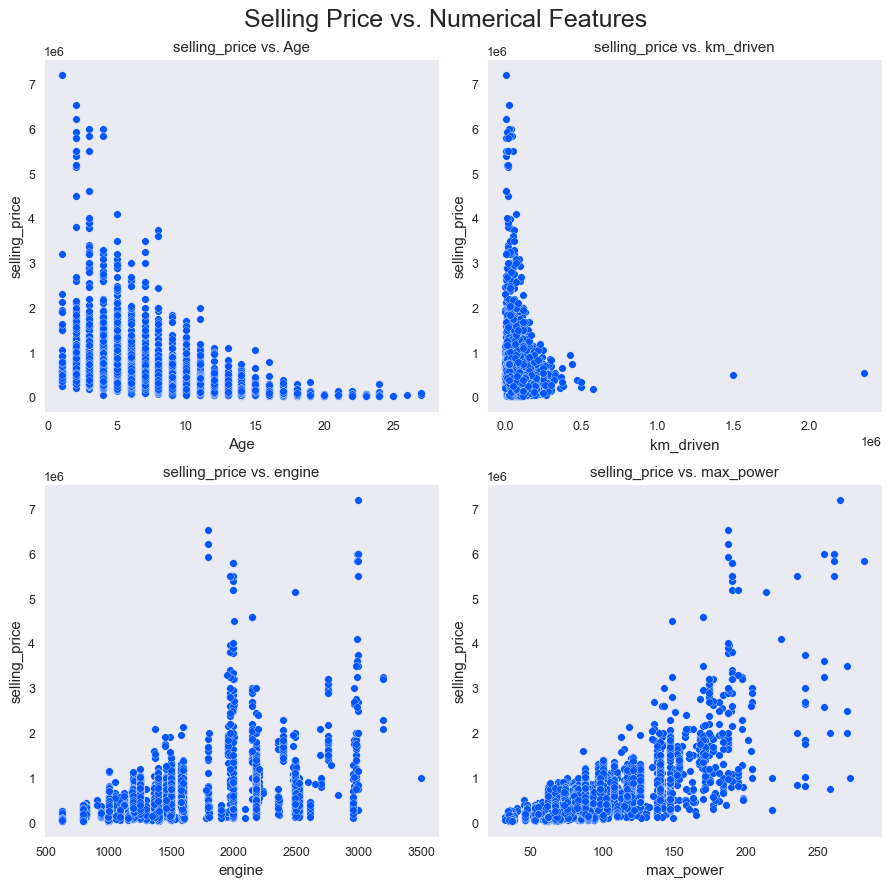

In [38]:
fig, ax = plt.subplots(nrows=2 ,ncols=2, figsize=(10,10), dpi=90)
num_features = ['Age', 'km_driven', 'engine', 'max_power']
target = 'selling_price'
c = '#0055ff'

for i in range(len(num_features)):
    row = i//2
    col = i%2
    ax[row,col].scatter(df1[num_features[i]], df1[target], color=c, edgecolors='w', linewidths=0.25)
    ax[row,col].set_title('{} vs. {}'.format(target, num_features[i]), size = 12)
    ax[row,col].set_xlabel(num_features[i], size = 12)
    ax[row,col].set_ylabel(target, size = 12)
    ax[row,col].grid()

plt.suptitle('Selling Price vs. Numerical Features', size = 20)
plt.tight_layout()
plt.show()

In [39]:
col_names=['Age','km_driven','engine','max_power']
col_vals=['negative','negative','positive','positive']
pd.DataFrame(col_vals,col_names,['selling price'])

,selling price
Age,negative
km_driven,negative
engine,positive
max_power,positive


## 4.4 Target vs. Categorical Features Bivariate Analysis

In [40]:
CatCols

['fuel', 'seller_type', 'transmission', 'owner', 'seats']

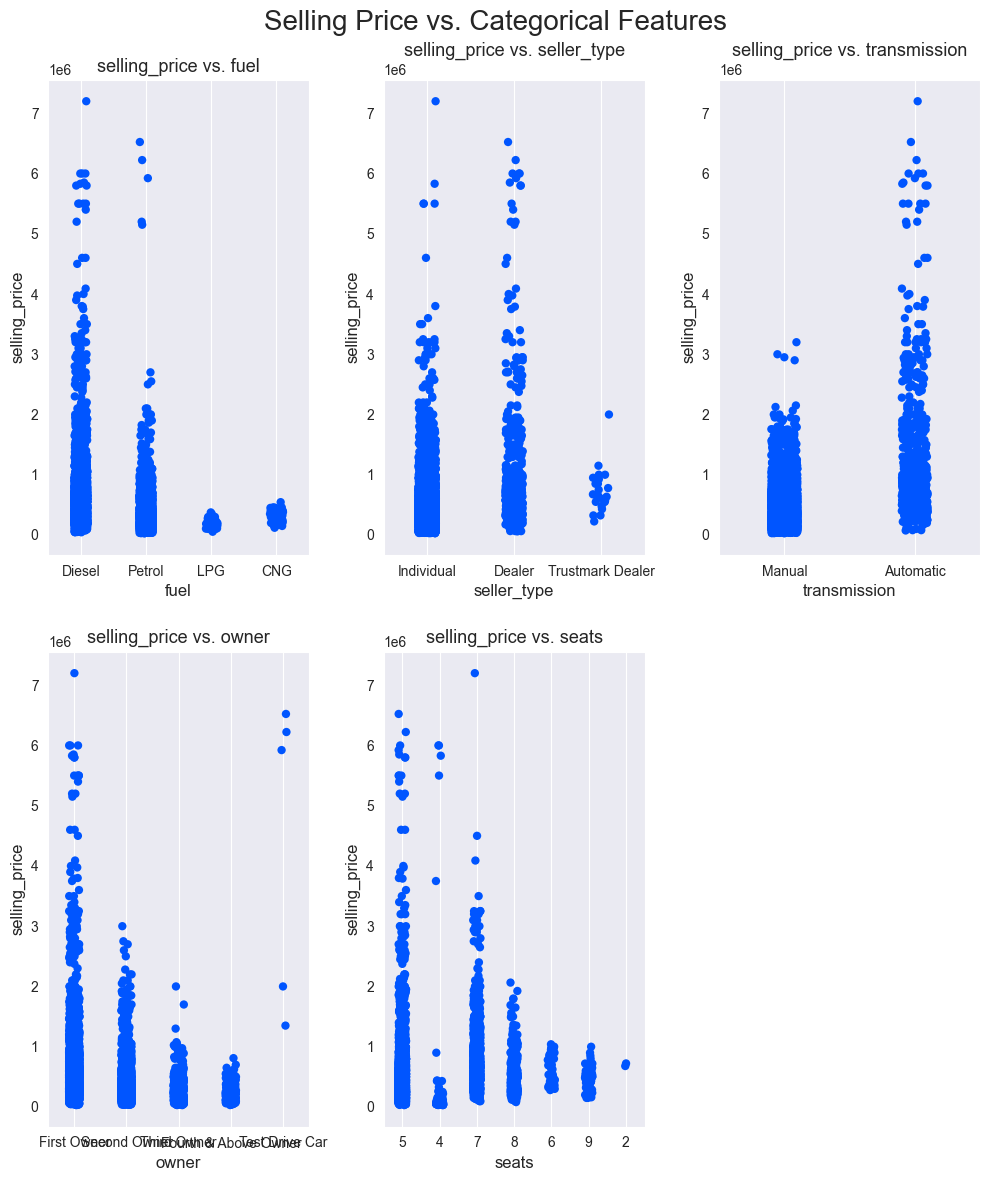

In [41]:
fig, axes = plt.subplots(nrows=2 ,ncols=3, figsize=(10,12), dpi=100)
cat_features = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']
target = 'selling_price'
c = '#0055ff'

for i in range(len(cat_features)):
    row = i//3
    col = i%3
    sns.stripplot(ax=axes[row,col], x=cat_features[i], y=target, data=df1, size=6, color=c)
    axes[row,col].set_title('{} vs. {}'.format(target, cat_features[i]), size = 13)
    axes[row,col].set_xlabel(cat_features[i], size = 12)
    axes[row,col].set_ylabel(target, size = 12)
    axes[row,col].grid()

plt.suptitle('Selling Price vs. Categorical Features', size = 20)
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

## 4.5 Multivariate Analysis

In [42]:
df1['transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

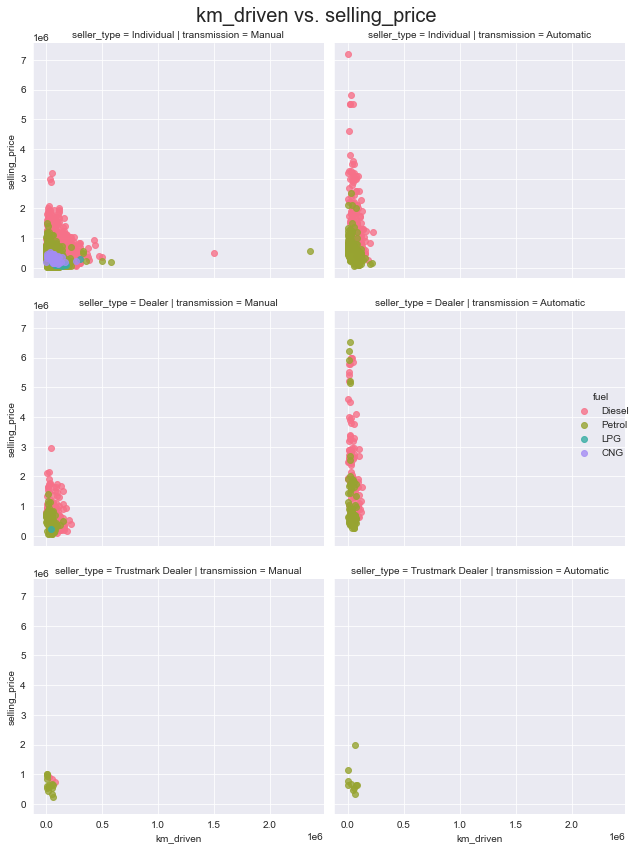

In [43]:
graph = sns.lmplot(x='km_driven', y='selling_price', data= df1, fit_reg=False, row='seller_type',
                   col='transmission', hue='fuel', palette=CustomPalette, height=4, aspect=1)   

plt.suptitle('km_driven vs. selling_price', fontsize=20) 
# sns.move_legend(graph, "lower center", bbox_to_anchor=(1.05, 0.5), ncol=1) #need to upgrade seaborn
plt.tight_layout()
plt.show()

In [ ]:
# LPG and CNG cars -> individual + manual
# almost no Diesel cars sold by Trustmark Dealer
# auto & dealer car tend to have lower km_driven while manual & deal have more km_driven

## 4.6 Categorical Variables Encoding

In [44]:
CatCols

df2 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df2.head(5)

,Age,selling_price,km_driven,engine,max_power,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,...,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,seats_4,seats_5,seats_6,seats_7,seats_8,seats_9
0,7,450000,145500,1248.0,74.0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,7,370000,120000,1498.0,103.0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,15,158000,140000,1497.0,78.0,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0
3,11,225000,127000,1396.0,90.0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,14,130000,120000,1298.0,88.0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


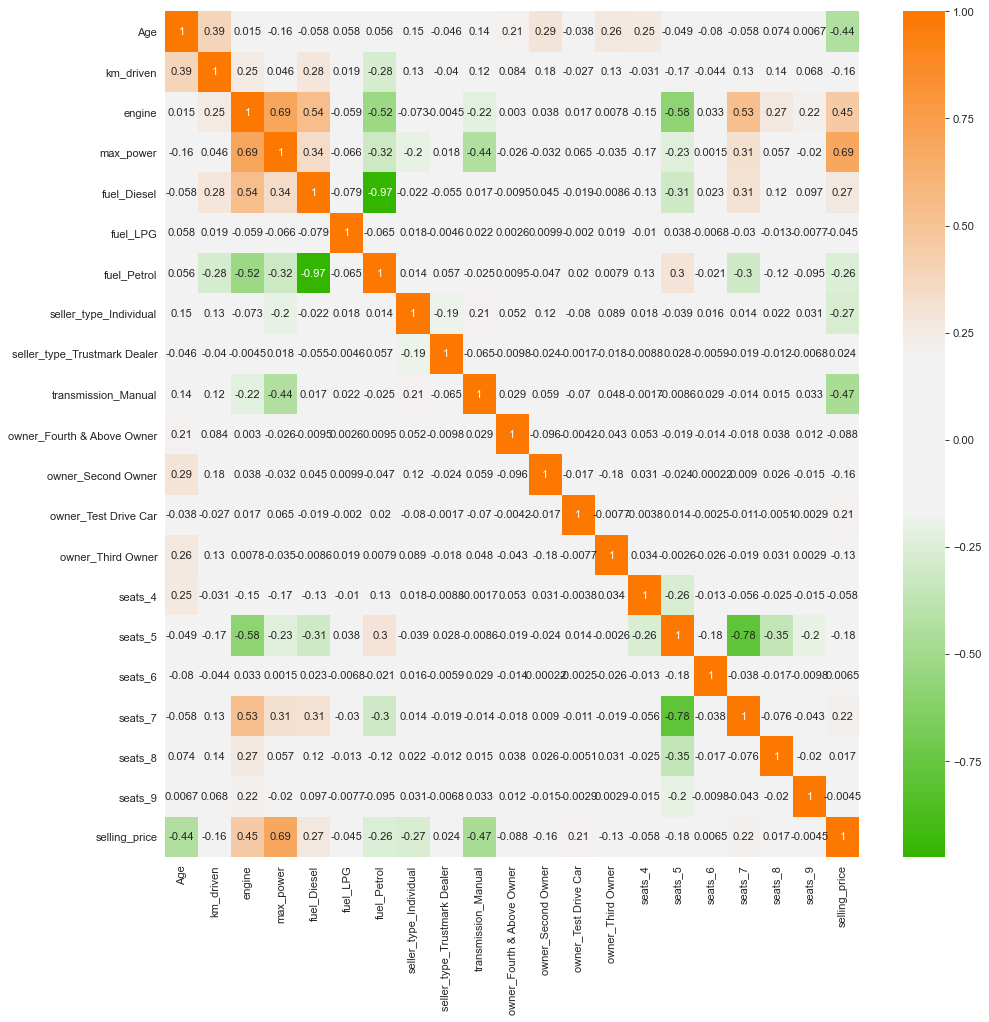

In [45]:
target = 'selling_price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 14), dpi=80)
ax = sns.heatmap(pd.concat([df2.drop(target,axis=1), df2[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

In [46]:
# Multicollinearity: max power and engine are highly correlated -> should drop one of them
df2 = df2.drop('max_power',axis=1)

# 5. Modeling

## 5.1 linear regression

In [47]:
X = df2.drop('selling_price', axis=1)
y = df2['selling_price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (4662, 19)
X_test shape:  (1999, 19)
y_train shape:  (4662,)
y_test shape:  (1999,)


In [50]:
y_test_actual = y_test

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [53]:
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), 
             index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,523655.083441
seats_5 Coef.,247218.442109
engine Coef.,235798.461686
seats_7 Coef.,174367.887337
seats_4 Coef.,130776.706343
owner_Test Drive Car Coef.,75383.021732
seats_8 Coef.,67599.814386
fuel_Diesel Coef.,64730.306789
seats_6 Coef.,36658.504687
fuel_Petrol Coef.,23778.147162


### 5.2 Model Evaluation

In [54]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

In [55]:
model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,1.873434e+05
MSE,1.107737e+11
RMSE,3.328269e+05
R2-Score,5.917377e-01


In [56]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.872660e+05,6.040245e+03
MSE,1.174040e+11,2.298757e+10
RMSE,3.409398e+05,3.411775e+04
R2-Score,5.512569e-01,3.911785e-02


#### By using cross-validation, we can have more confidence in our estimation for the model evaluation metrics than the former simple train-test split:
#### Pipeline is a great way to prevent data leakage as it ensures that the appropriate method is performed on the correct data subset. This is ideal for using in cross-validation since it ensures that only the training folds are used when performing fit and the test set (validation set) is used only for calculating the accuracy score in each iteration of cross-validation.

### 5.3.1 Assumption 1 - Linearity
#### Plots of actual vs. predicted values -> The desired outcome is that points are symmetrically distributed around a diagonal line
#### Plots of residuals vs. predicted values -> The desired outcome is that points are symmetrically distributed around a horizontal line
#### * plot shows no linearity between dependent var and independent var

In [57]:
def residuals(model, X_test, y_test):
    '''
    Creates predictions on the features with the model and calculates residuals
    '''
    y_pred = model.predict(X_test)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [58]:
def linear_assumption(model, X_test, y_test):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model
    '''
    df_results = residuals(model, X_test, y_test)
    
    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', data=df_results, lowess=True, ax=ax[0],
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    ax[0].set_title('Actual vs. Predicted Values', fontsize=15)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)        
    
    sns.regplot(x='Predicted', y='Residuals', data=df_results, lowess=True, ax=ax[1],
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=15)
    ax[1].set_xlabel('Predicted', fontsize=12)
    ax[1].set_ylabel('Residuals', fontsize=12)  

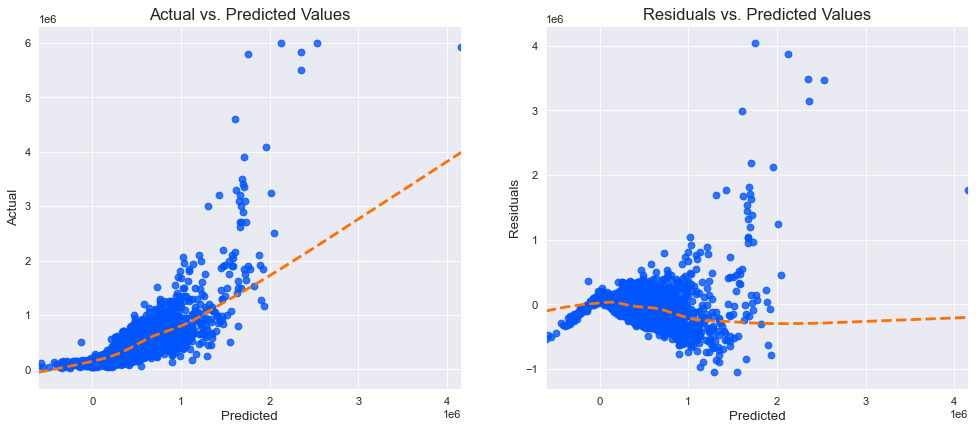

In [60]:
linear_assumption(linear_reg, X_test_scaled, y_test)

### 5.3.2 Assumption 2 - Normality of Residuals
#### Check residuals histogram
#### Quantile-Quantile probability plot -> plotting the residuals vs the order of statistic

In [61]:
def normal_errors_assumption(model, X_test, y_test, p_value_thresh=0.05):
    '''
    Function for inspecting the assumption of normality of residuals.
    '''
    df_results = residuals(model, X_test, y_test)
    
    # Anderson-Darling Test
    p_value = normal_ad(df_results['Residuals'])[1]
    
    print('\nP-value from the test (below 0.05 generally means non-normal):  ', np.round(p_value,6))
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed. Assumption not satisfied.') 
    else:
        print('Residuals are normally distributed. Assumption satisfied.')

      
    # Residuals Histogram
    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
    
    sns.histplot(data=df_results, x='Residuals', kde=True, ax=ax[0], bins=15, 
                 color='#0055ff', edgecolor='none', alpha=0.4, line_kws={'lw': 2.5})
    ax[0].set_xlabel('Residuals', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_title('Distribution of Residuals', fontsize=15)
    textstr = '\n'.join((
        r'$\mu=%.2f$' %np.mean(df_results['Residuals']),
        r'$\sigma=%.2f$' %np.std(df_results['Residuals']),
        ))
    ax[0].text(0.7, 0.9, textstr, transform=ax[0].transAxes, fontsize=15, verticalalignment='top',
                 bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))
    
    
    # Q-Q Probability Plot
    stats.probplot(df_results['Residuals'], dist="norm", plot= ax[1])
    ax[1].set_title("Residuals Q-Q Plot", fontsize=15)
    ax[1].set_xlabel('Theoretical Quantiles', fontsize=12)
    ax[1].set_ylabel('Ordered Values', fontsize=12)
    ax[1].get_lines()[0].set_markerfacecolor('#509aff')
    ax[1].get_lines()[1].set_color('#ff7000')
    ax[1].get_lines()[1].set_linewidth(2.5)
    ax[1].get_lines()[1].set_linestyle('--')
    ax[1].legend(['Actual','Theoretical'])
    
    plt.show()

/Users/shengnan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),



P-value from the test (below 0.05 generally means non-normal):   0.0
Residuals are not normally distributed. Assumption not satisfied.


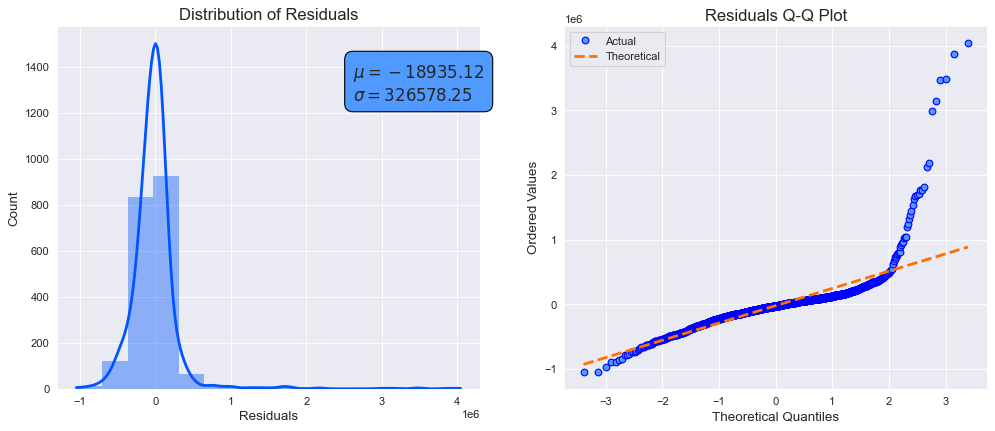

In [62]:
normal_errors_assumption(linear_reg, X_test_scaled, y_test)

#### The bow-shaped pattern of deviations from the diagonal implies that the residuals have excessive skewness.
#### The s-shaped pattern of deviations from the diagonal implies excessive kurtosis of the residuals (there are either too many or too few large errors in both directions.)

### 5.3.3 Assumption 3 - Multicollinearity

In [63]:
def multicollinearity_assumption(X):
    ''''
    This assumes that predictors are not correlated with each other and calculates VIF values of predictors
    '''
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    possible_multicollinearity = sum([1 for v in vif if v > 10])
    definite_multicollinearity = sum([1 for v in vif if v > 100])
    
    print('{} cases of possible multicollinearity.'.format(possible_multicollinearity))
    print('{} cases of definite multicollinearity.'.format(definite_multicollinearity))
    
    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied.')
        else:
            print('Assumption possibly satisfied.')
    else:
        print('Assumption not satisfied.')
    
    return pd.DataFrame({'vif': vif}, index=X.columns).round(2)

In [64]:
multicollinearity_assumption(X)

7 cases of possible multicollinearity.
1 cases of definite multicollinearity.
Assumption not satisfied.


,vif
Age,7.77
km_driven,3.53
engine,24.30
fuel_Diesel,70.79
fuel_LPG,1.67
fuel_Petrol,57.08
seller_type_Individual,10.85
seller_type_Trustmark Dealer,1.05
transmission_Manual,14.08
owner_Fourth & Above Owner,1.13


##### need to drop col seats_5

### 5.3.4 Assumption 4 -- No Autocorrelation of Residuals
##### Durbin-Watson test
##### The test statistic always has a value between 0 and 4
##### Values of 1.5 < d < 2.5 means that there is no autocorrelation in the data
##### Values < 1.5 indicate positive autocorrelation, values > 2.5 indicate negative autocorrelation

In [65]:
def autocorrelation_assumption(model, X_test, y_test):
    '''
    It assumes that there is no autocorrelation in the residuals. If there is autocorrelation, then 
    there is a pattern that is not explained because the current value is dependent on the previous value.
    '''
    df_results = residuals(model, X_test, y_test)

    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', round(durbinWatson,3))
    
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation. Assumption not satisfied.', '\n')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation. Assumption not satisfied.', '\n')
    else:
        print('Little to no autocorrelation. Assumption satisfied.', '\n')

In [66]:
autocorrelation_assumption(linear_reg, X_test_scaled, y_test)

Durbin-Watson: 2.004
Little to no autocorrelation. Assumption satisfied. 



### 5.3.5 Assumption 5 - Homoscedasticity
##### Homoscedasticity means that the residuals doesn’t change across all the values of the target variable. When residuals do not have constant variance, it is difficult to determine the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide/narrow. The effect of heteroscedasticity might also be putting too much weight to a subset of data when estimating coefficients. To investigate if the residuals are homoscedastic, we can look at a plot of residuals vs. predicted values. The placement of the points should be random and no pattern (increase/decrease in values of residuals) should be visible.

In [67]:
def homoscedasticity_assumption(model, X_test, y_test):
    """
    Homoscedasticity assumes that the residuals exhibit constant variance
    """
    print('The orange line should be flat:')
    df_results = residuals(model, X_test, y_test)
    
    fig = plt.figure(figsize=(6,6), dpi=80)
    sns.regplot(x='Predicted', y='Residuals', data=df_results, lowess=True,
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    plt.axhline(y=0, color='#23bf00', lw=1)
    plt.title('Residuals vs. Predicted Values', fontsize=15)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)    
    plt.show()

The orange line should be flat:


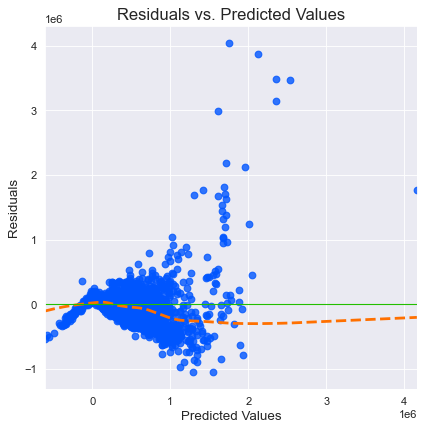

In [68]:
homoscedasticity_assumption(linear_reg, X_test_scaled, y_test)

#### We can not see a fully uniform variance across our residuals because the orange line is not flat. The assumption is not satisfied.

# 6 Solution from assumption
#### In the following:
##### 1. To satisfy the multicollinearity assumption, we remove the col seats_5 feature.
##### 2. Then, according to the pattern in the plot of the residuals vs. predicted values, we will use box-cox transformation on the entire dataset.
##### 3. By applying polynomial regression, we will try to improve the satisfaction of homoscedasticity and normality of residuals.
##### 4. Finally, we will use regularization to reduce the probability of the model to be overfit.

#### 1. delete seats_5

In [373]:
# del df2['seats_5']

In [69]:
del X['seats_5']

In [70]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

In [71]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=20)
    plt.ylabel('Selling_Price', fontsize=15)
    plt.show()

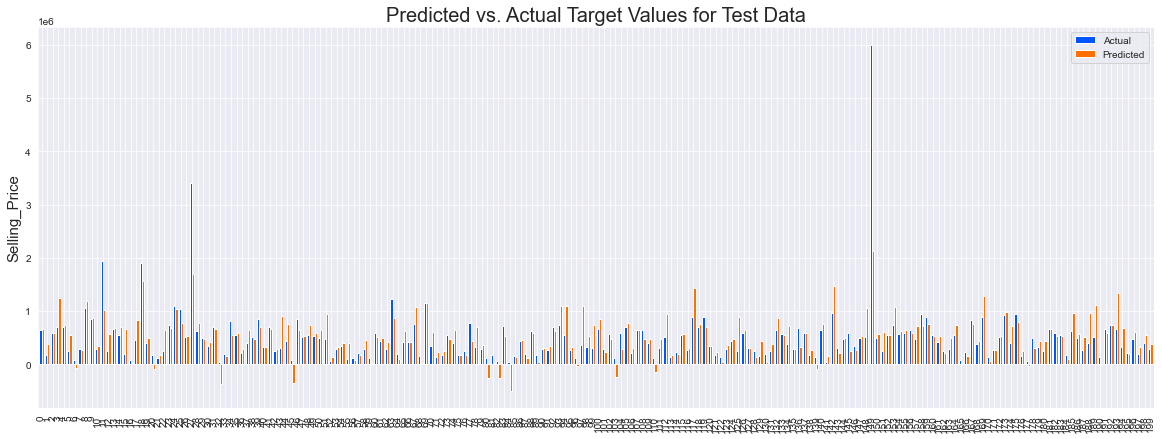

In [72]:
compare_plot(df_comp.sample(200))

##### 2. Then, according to the pattern in the plot of the residuals vs. predicted values, we will use box-cox transformation on the entire dataset.

In [73]:
fitted_lambda = pd.Series(np.zeros(len(df2.columns), dtype=np.float64), index=df2.columns)

y_train, fitted_lambda['selling_price'] = stats.boxcox(y_train+1)
for col in X_train.columns:
    X_train[col], fitted_lambda[col] = stats.boxcox(X_train[col]+1)
    
fitted_lambda

<ipython-input-73-6cf48afc8797>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col], fitted_lambda[col] = stats.boxcox(X_train[col]+1)


Age                                0.210516
selling_price                      0.057132
km_driven                          0.337173
engine                            -0.522758
fuel_Diesel                        0.635694
fuel_LPG                        -305.704916
fuel_Petrol                       -0.828091
seller_type_Individual            14.773382
seller_type_Trustmark Dealer    -305.704916
transmission_Manual               16.801183
owner_Fourth & Above Owner       -63.428571
owner_Second Owner                -4.366786
owner_Test Drive Car           -1680.946531
owner_Third Owner                -19.214417
seats_4                          -73.890043
seats_5                            6.266232
seats_6                         -168.094650
seats_7                           -9.933790
seats_8                          -42.819748
seats_9                         -129.275565
dtype: float64

In [74]:
#Transform Test Data Using Lambda Values
y_test = stats.boxcox(y_test+1, fitted_lambda['selling_price'])
for col in X_test.columns:
    X_test[col] = stats.boxcox(X_test[col]+1, fitted_lambda[col])

<ipython-input-74-ee0289367d8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = stats.boxcox(X_test[col]+1, fitted_lambda[col])


In [75]:
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['selling_price'])
y_test = pd.DataFrame(y_test, index=X_test.index, columns=['selling_price'])

X_boxcox = pd.concat([X_train, X_test])
y_boxcox = pd.concat([y_train, y_test])

df_boxcox = pd.concat([X_boxcox, y_boxcox], axis=1)
df_boxcox.sort_index(inplace=True)

del df_boxcox['seats_5']

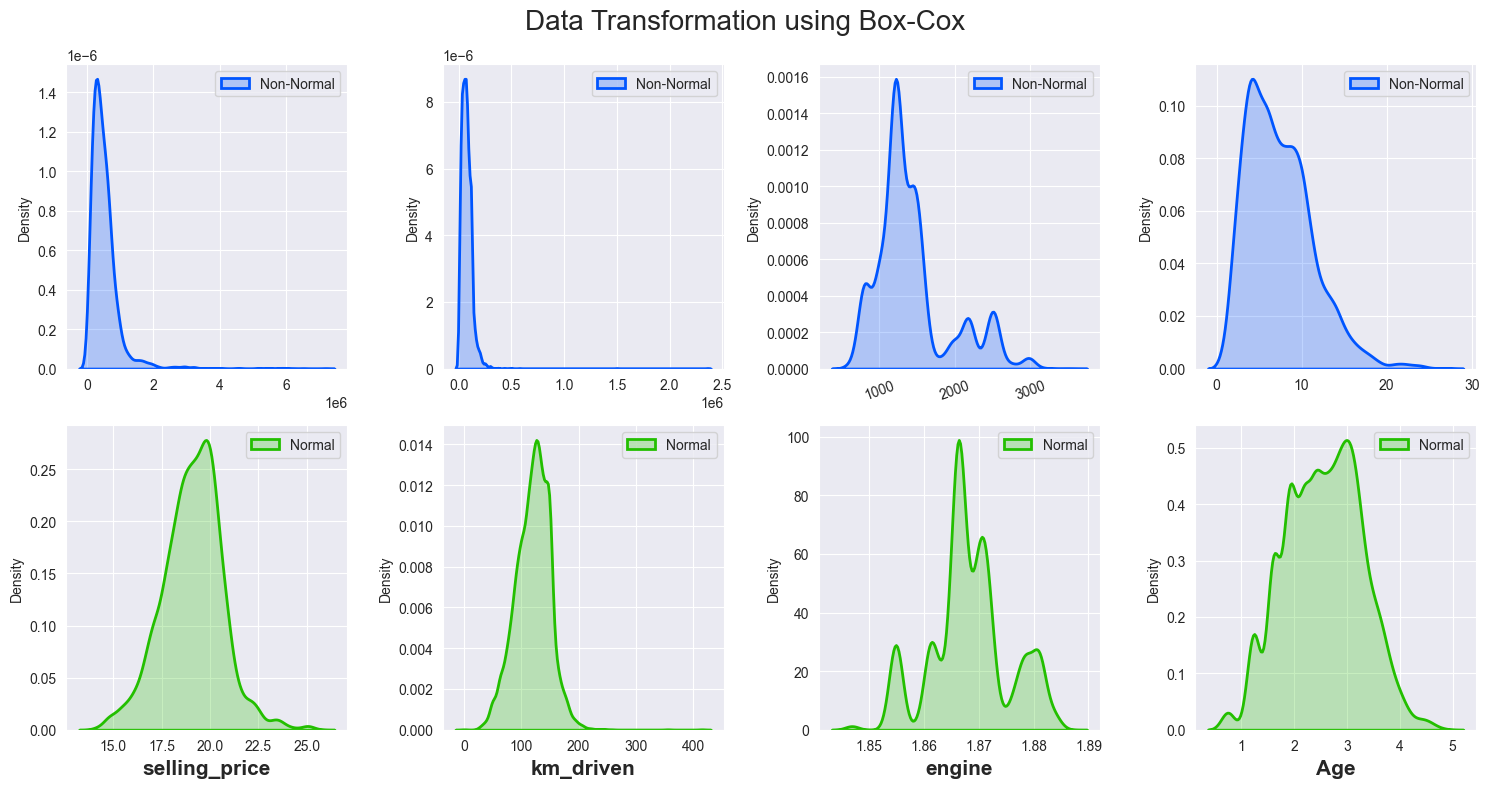

In [76]:
fig, ax = plt.subplots(2, 4, figsize=(15,8), dpi=100)
columns = ['selling_price', 'km_driven', 'engine', 'Age']

for i,col in enumerate(columns):
    sns.kdeplot(df2[col], label="Non-Normal", fill=True, color='#0055ff', linewidth=2, ax=ax[0,i])
    sns.kdeplot(df_boxcox[col], label="Normal", fill=True, color='#23bf00', linewidth=2, ax=ax[1,i])  
    ax[0,i].set_xlabel('', fontsize=15)
    ax[1,i].set_xlabel(col, fontsize=15, fontweight='bold')
    ax[0,i].legend(loc="upper right")
    ax[1,i].legend(loc="upper right")

ax[0,2].tick_params(axis='x', labelrotation = 20)
plt.suptitle('Data Transformation using Box-Cox', fontsize=20)
plt.tight_layout()
plt.show()

##### As can be seen, the distribution of the variables is closer to the normal distribution after applying Box-Cox.

In [109]:
# Now box-cox transformation is applied on X and y. Next, we will add higher order features to the model.
X = df_boxcox.drop('selling_price', axis=1)
y = df_boxcox['selling_price']

##### 3. By applying polynomial regression, we will try to improve the satisfaction of homoscedasticity and normality of residuals.

In [89]:
X.columns

Index(['Age', 'km_driven', 'engine', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Individual', 'seller_type_Trustmark Dealer',
       'transmission_Manual', 'owner_Fourth & Above Owner',
       'owner_Second Owner', 'owner_Test Drive Car', 'owner_Third Owner',
       'seats_4', 'seats_6', 'seats_7', 'seats_8', 'seats_9'],
      dtype='object')

In [90]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names(X.columns))
X_poly.head(5)

,Age,km_driven,engine,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,...,seats_6^2,seats_6 seats_7,seats_6 seats_8,seats_6 seats_9,seats_7^2,seats_7 seats_8,seats_7 seats_9,seats_8^2,seats_8 seats_9,seats_9^2
0,2.608953,160.312157,1.866911,0.870993,0.0,0.000000,1895.552337,0.0,6796.988182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.608953,150.041626,1.871097,0.870993,0.0,0.000000,1895.552337,0.0,6796.988182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.765095,158.204500,1.871083,0.000000,0.0,0.527389,1895.552337,0.0,6796.988182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.264698,152.994652,1.869528,0.870993,0.0,0.000000,1895.552337,0.0,6796.988182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.650185,150.041626,1.867845,0.000000,0.0,0.527389,1895.552337,0.0,6796.988182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
poly_features_names = poly_features.get_feature_names(X.columns)
len(poly_features_names)

189

In [93]:
#Split Dataset to Training & Test Sets
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

In [94]:
print('X_poly_train shape: ', X_poly_train.shape)
print('X_poly_test shape: ', X_poly_test.shape)
print('y_poly_train shape: ', y_poly_train.shape)
print('y_poly_test shape: ',y_poly_test.shape)

X_poly_train shape:  (4662, 189)
X_poly_test shape:  (1999, 189)
y_poly_train shape:  (4662,)
y_poly_test shape:  (1999,)


In [95]:
# Scale Data using Standard Scaler
scaler = StandardScaler()
scaler.fit(X_poly_train)

X_poly_train = scaler.transform(X_poly_train)
X_poly_train = pd.DataFrame(X_poly_train, columns=poly_features_names)

X_poly_test = scaler.transform(X_poly_test)
X_poly_test = pd.DataFrame(X_poly_test, columns=poly_features_names)

In [96]:
# Create Polynomial Regression Model using Linear Regression
polynomial_reg = LinearRegression()
polynomial_reg.fit(X_poly_train, y_poly_train)

LinearRegression()

In [97]:
# Model Evaluation
# 2nd-order Polynomial Model Performance on Test Data:
model_evaluation(polynomial_reg, X_poly_test, y_poly_test, 'Polynomial Reg. Test')

,Polynomial Reg. Test
MAE,0.490251
MSE,0.428289
RMSE,0.654438
R2-Score,0.828967


In [98]:
# 2nd-order Polynomial Model Performance on Training Data:
model_evaluation(polynomial_reg, X_poly_train, y_poly_train, 'Polynomial Reg. Train')

,Polynomial Reg. Train
MAE,0.476527
MSE,0.388617
RMSE,0.623392
R2-Score,0.839633


##### As can be seen, using boxcox transformation and production of second-order features has improved the model performance greatly!
##### The accuracy of the model on the training and test data are close to each other, so the model is not overfit.
##### The production of third-order and higher features was also tested, which caused the model to become overfit.

In [110]:
# Model Evaluation using Cross-Validation???
pipeline = make_pipeline(PolynomialFeatures(degree=2,include_bias=False), StandardScaler(),LinearRegression())

kf = KFold(n_splits=2, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result2 = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result2['test_neg_mean_absolute_error']).mean()
MAE_std = (-result2['test_neg_mean_absolute_error']).std()
MSE_mean = (-result2['test_neg_mean_squared_error']).mean()
MSE_std = (-result2['test_neg_mean_squared_error']).std()
RMSE_mean = (-result2['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result2['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result2['test_r2'].mean()
R2_Score_std = result2['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.390623e+10,9.225888e+08
MSE,3.224316e+23,1.682173e+23
RMSE,5.465823e+11,1.538810e+11
R2-Score,-1.288443e+23,6.279146e+22


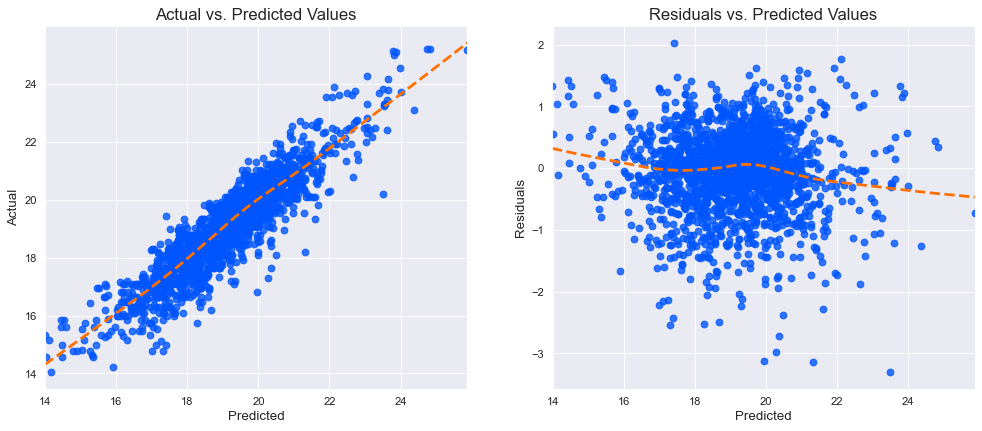

In [111]:
# Assumptions Investigation
# Assumption 1 - Linearity
linear_assumption(polynomial_reg, X_poly_test, y_poly_test)


P-value from the test (below 0.05 generally means non-normal):   0.0
Residuals are not normally distributed. Assumption not satisfied.


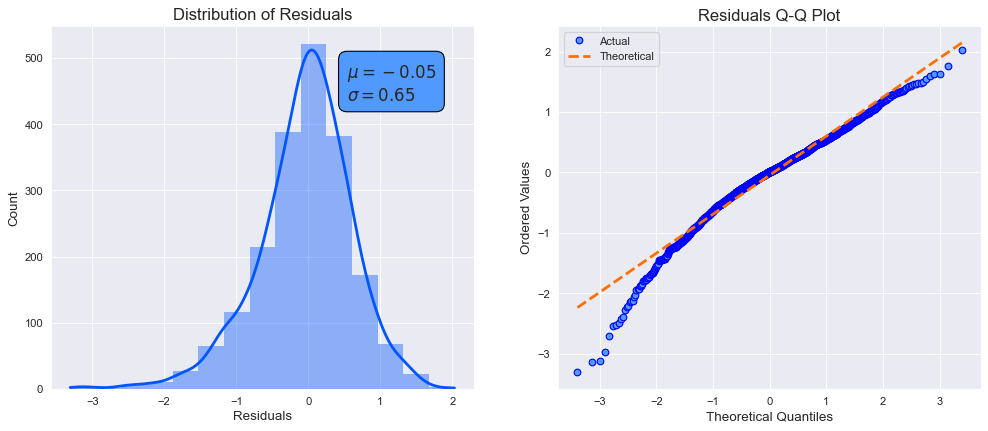

In [112]:
# Assumption 2 - Normality of Residuals
normal_errors_assumption(polynomial_reg, X_poly_test, y_poly_test)

In [113]:
# Assumption 3 - No Perfect Multicollinearity
warnings.simplefilter(action='ignore')
multicollinearity_assumption(X_poly).T

127 cases of possible multicollinearity.
84 cases of definite multicollinearity.
Assumption not satisfied.


,Age,km_driven,engine,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,...,seats_6^2,seats_6 seats_7,seats_6 seats_8,seats_6 seats_9,seats_7^2,seats_7 seats_8,seats_7 seats_9,seats_8^2,seats_8 seats_9,seats_9^2
vif,353236.07,369113.42,1023391.75,4.503600e+15,inf,9.007199e+15,inf,1.200160e+12,inf,inf,...,inf,NaN,NaN,NaN,8.417943e+13,NaN,NaN,9.481262e+13,NaN,inf


In [114]:
# Assumption 4 - No Autocorrelation of Residuals
autocorrelation_assumption(polynomial_reg, X_poly_test, y_poly_test)

Durbin-Watson: 1.944
Little to no autocorrelation. Assumption satisfied. 



The orange line should be flat:


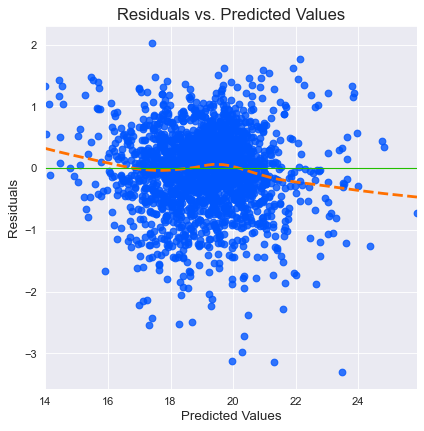

In [115]:
# Assumption 5 - Homoscedasticity
homoscedasticity_assumption(polynomial_reg, X_poly_test, y_poly_test)